<a href="https://colab.research.google.com/github/stefisha/NordeusChallenge/blob/main/NordeusChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [ ]:
# Load the datasets
train_data = pd.read_csv('/content/drive/MyDrive/Nordeus Challenge/jobfair_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Nordeus Challenge/jobfair_test.csv')

In [ ]:
test_data.head()

,season,club_id,league_id,dynamic_payment_segment,cohort_season,avg_age_top_11_players,avg_stars_top_11_players,avg_stars_top_14_players,avg_training_factor_top_11_players,days_active_last_28_days,...,playtime_last_28_days,registration_country,registration_platform_specific,league_match_won_count_last_28_days,training_count_last_28_days,global_competition_level,tokens_spent_last_28_days,tokens_stash,rests_stash,morale_boosters_stash
0,174,14542747,2951383,0) NonPayer,1,23,4.295345,4.100333,0.469406,8,...,2580346,France,iOS Phone,10,6,NaN,82,18,177,106
1,174,11019672,2954266,0) NonPayer,21,24,4.704727,4.484933,0.317702,28,...,15521681,Indonesia,Android Phone,16,26,7.0,153,65,1030,717
2,174,14358567,2951259,0) NonPayer,2,22,2.923867,2.819171,0.669540,0,...,0,Brazil,Android Phone,7,0,NaN,0,138,156,98
3,174,14644461,2949546,0) NonPayer,1,22,3.114776,2.977457,0.639923,3,...,1136208,Spain,Android Phone,2,1,NaN,2,43,43,25
4,174,13718978,2952772,0) NonPayer,6,23,4.194497,4.114257,0.486229,26,...,43655679,France,Android Phone,22,46,1.0,100,30,45,53


In [ ]:
# Identify categorical and numerical columns
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [ ]:
# Remove the target variable and identifiers from the numerical columns list
numerical_cols.remove('league_rank')
numerical_cols.remove('club_id')
numerical_cols.remove('league_id')

In [ ]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()) # maybe unnecessary
])

In [ ]:
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [ ]:
# Separate target from predictors
X_train = train_data.drop(['club_id', 'league_id', 'league_rank'], axis=1)
y_train = train_data['league_rank']
X_test = test_data.drop(['club_id', 'league_id'], axis=1)

In [ ]:
# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
# Convert the preprocessed training data to a DataFrame
ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
feature_names = list(numerical_cols) + list(ohe_feature_names)
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed.toarray(), columns=feature_names)

In [ ]:
# Define the model
model = RandomForestClassifier(random_state=0, n_estimators=100)

In [ ]:
# Perform cross-validation
cv_scores = -1 * cross_val_score(model, X_train_preprocessed_df, y_train, cv=5, scoring='neg_mean_absolute_error')

In [ ]:
# Print the mean and standard deviation of the cross-validation scores
print(f'Mean MAE: {cv_scores.mean()}')
print(f'Standard Deviation of MAE: {cv_scores.std()}')

Mean MAE: 2.804823277305649
Standard Deviation of MAE: 0.01069693462599373


In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# # Define a simple Decision Tree Classifier
# dt_model = DecisionTreeClassifier(random_state=0)

# # Perform cross-validation to evaluate the model using Mean Absolute Error
# # We multiply by -1 because sklearn's cross-validation functions maximize utility functions, so they treat MAE as negative
# dt_cv_scores = -1 * cross_val_score(dt_model, X_train_preprocessed, y_train, cv=5, scoring='neg_mean_absolute_error')

# # Compute the mean and standard deviation of the cross-validation scores
# dt_cv_mae_mean = dt_cv_scores.mean()
# dt_cv_mae_std = dt_cv_scores.std()

# dt_cv_mae_mean, dt_cv_mae_std

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Adjust the target variable to start from 0
y_train_adjusted = y_train - 1

# Define the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=0, num_class=14)

# Perform cross-validation
xgb_cv_scores = -1 * cross_val_score(xgb_model, X_train_preprocessed, y_train_adjusted, cv=5, scoring='neg_mean_absolute_error')

# Compute the mean and standard deviation of the cross-validation scores
xgb_cv_mae_mean = xgb_cv_scores.mean()
xgb_cv_mae_std = xgb_cv_scores.std()

print(f"XGBoost Mean MAE: {xgb_cv_mae_mean}")
print(f"XGBoost Standard Deviation of MAE: {xgb_cv_mae_std}")

XGBoost Mean MAE: 2.8026721533202794
XGBoost Standard Deviation of MAE: 0.007569005956402721


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.6),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

# Initialize XGBoost model
#xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=0, num_class=14)
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    random_state=0,
    num_class=14,
    #early_stopping_rounds=10,
    eval_metric="mae",
    verbose=True
)

# RandomizedSearchCV
#random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=25, scoring='neg_mean_absolute_error', cv=5, random_state=0, verbose=3)
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=0,
    verbose=10,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train_preprocessed, y_train_adjusted)

# Print the best parameters and lowest MAE
print("Best parameters found: ", random_search.best_params_)
print("Lowest MAE found: ", -random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'colsample_bytree': 0.6044383780474174, 'gamma': 0.08065475894249813, 'learning_rate': 0.4018649952792391, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 277, 'subsample': 0.8117550505659341}
Lowest MAE found:  2.783906076101056


In [ ]:
# Train the final model with the best parameters
final_xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    colsample_bytree=0.6044,
    gamma=0.0807,
    learning_rate=0.4019,
    max_depth=3,
    min_child_weight=5,
    n_estimators=277,
    subsample=0.8118,
    random_state=0,
    num_class=14
)

final_xgb_model.fit(X_train_preprocessed, y_train_adjusted)

# Feature importance, predictions, and further evaluation can follow


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6044, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0807, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4019, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=277, n_jobs=None, num_class=14,
              num_parallel_tree=None, ...)

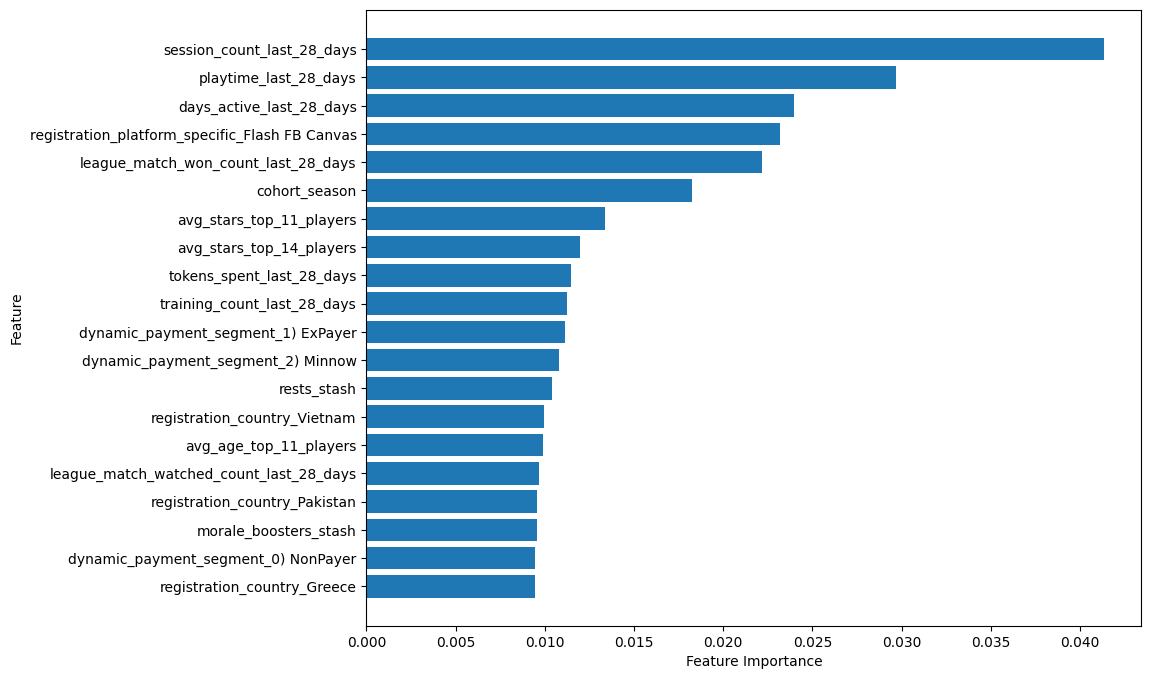

In [ ]:
import matplotlib.pyplot as plt

# Train the final model with the best parameters
final_xgb_model.fit(X_train_preprocessed, y_train_adjusted)

# Get feature importance
feature_importances = final_xgb_model.feature_importances_

# Assuming 'feature_importances' is a list/array of importances and 'feature_names' is a list of feature names
# Sort features by their importance scores
sorted_idx = feature_importances.argsort()

# Select the top N features (e.g., top 20)
top_n = 20
sorted_idx_top = sorted_idx[-top_n:]

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx_top)), feature_importances[sorted_idx_top], align='center')
plt.yticks(range(len(sorted_idx_top)), [feature_names[i] for i in sorted_idx_top])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
# Adjust the test data if it has not been preprocessed
# X_test_preprocessed = preprocessor.transform(X_test)

# Make predictions
predictions = final_xgb_model.predict(X_test_preprocessed)

# Adjust predictions back to original scale (if you subtracted 1 earlier)
predictions_adjusted = predictions + 1


In [ ]:
predictions_adjusted

array([10,  3,  3, ...,  6,  1,  3])

In [ ]:
# Create a DataFrame for submission
submission = pd.DataFrame({
    'club_id': test_data['club_id'],
    'predicted_league_rank': predictions_adjusted
})

# Display the first few rows of the submission DataFrame
submission.head()


,club_id,predicted_league_rank
0,14542747,10
1,11019672,3
2,14358567,3
3,14644461,13
4,13718978,2


In [ ]:
# Save the DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)